## Curvas de exhaustividad- precisión y curvas ROC

Cambiar el umbral que se usa para tomar una decisión de clasificación en un modelo es una forma de ajustar la compensación de precisión y exhaustividad para un clasificador dado. Tal vez quiera perder menos del 10% de muestras positivas, lo que significa que se tendrá una exhaustividad del 90%. Esta decisión depende de la aplicación, y debe ser impulsada por los objetivos comerciales. Una vez que se establece un objetivo en particular, es decir, una exhaustividad particular o un valor de precisión para una clase, se puede establecer un umbral de manera apropiada. Siempre es posible establecer un umbral para cumplir un objetivo en particular, como un 90% de exhaustividad. La parte difícil es desarrollar un modelo que todavía tenga una precisión razonable con este umbral: si clasifica todo como positivo, tendrá un 100% de exhaustividad, pero su modelo será inútil.

Establecer un requisito en un clasificador como 90% de exhaustividad a menudo se llama establecer el punto de operación. El ajuste  de un punto de operación suele ser útil en la configuración empresarial para garantizar el rendimiento a los clientes u otros grupos dentro de su organización.

A menudo, al desarrollar un nuevo modelo, no está del todo claro cuál será el punto de operación. Por esta razón y para comprender mejor un problema de modelado, es instructivo observar todos los umbrales posibles, o todos los posibles intercambios de precisión y exhaustividad a la vez. Esto es posible usando una herramienta llamada curva de precision-exhaustividad. 


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import numbers
from sklearn.utils import check_array, check_random_state
from sklearn.utils import shuffle as shuffle_


def hacer_blobs(n_muestras=100, n_caracteristica=2, centros=2, cluster_std=1.0,
centro_caja=(-10.0, 10.0), shuffle=True, random_state=None):
    
    generador = check_random_state(random_state)

    if isinstance(centros, numbers.Integral):
        centros = generador.uniform(centro_caja[0], centro_caja[1],
                                    size=(centros, n_caracteristica))
    else:
        centros = check_array(centros)
        n_caracteristica = centros.shape[1]

    if isinstance(cluster_std, numbers.Real):
        cluster_std = np.ones(len(centros)) * cluster_std

    X = []
    y = []

    n_centros = centros.shape[0]
    if isinstance(n_muestras, numbers.Integral):
        n_muestras_por_centro = [int(n_muestras // n_centros)] * n_centros
        for i in range(n_muestras % n_centros):
            n_muestras_por_centro[i] += 1
    else:
        n_muestras_por_centro = n_muestras

    for i, (n, std) in enumerate(zip(n_muestras_por_centro, cluster_std)):
        X.append(centros[i] + generador.normal(scale=std,
                                               size=(n, n_caracteristica)))
        y += [i] * n

    X = np.concatenate(X)
    y = np.array(y)

    if shuffle:
        X, y = shuffle_(X, y, random_state=generador)

    return X, y

In [4]:
from sklearn.svm import SVC
X, y = hacer_blobs(n_muestras=(400, 50), centros=2, cluster_std=[7.0, 2],
                      random_state=22)
X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(X, y, random_state=0)
svc = SVC(gamma=.05).fit(X_entrenamiento, y_entrenamiento)

In [7]:
from sklearn.metrics import precision_recall_curve
precision, exhaustividad, umbrales = precision_recall_curve(y_prueba, svc.decision_function(X_prueba))


La función `precision_recall_curve` devuelve una lista de valores de precisión y exhaustividad para todos los umbrales posibles (todos los valores que aparecen en la función de decisión) en orden, para que podamos dibujar una curva, como se ve en la siguiente figura:

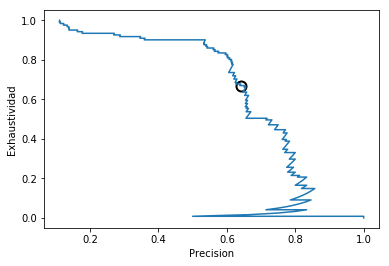

In [10]:
# Usamos mas puntos datos para una curva suave
X, y = hacer_blobs(n_muestras=(4000, 500), centros=2, cluster_std=[7.0, 2],random_state=22)
X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(X, y, random_state=0)
svc = SVC(gamma=.05).fit(X_entrenamiento, y_entrenamiento)
precision,exhaustividad, umbrales = precision_recall_curve(y_prueba, svc.decision_function(X_prueba))

# encontramos umbrales cercanos a cero
cerca_cero = np.argmin(np.abs(umbrales))
plt.plot(precision[cerca_cero], exhaustividad[cerca_cero], 'o', markersize=10,
label="umbral cero", fillstyle="none", c='k', mew=2)
plt.plot(precision, exhaustividad, label="Curva precision-exhaustividad")
plt.xlabel("Precision")
plt.ylabel("Exhaustividad")
plt.show()

Cada punto a lo largo de la curva en la figura anterior corresponde a un umbral posible de `decision_function`. Podemos ver, por ejemplo, que podemos lograr una exhaustividad de 0.4 con una precisión de aproximadamente 0.75. El círculo negro marca el punto que corresponde a un umbral de 0, el umbral predeterminado para `decision_function`. Este punto es el término medio que se elige al llamar al método `predict`.

Cuanto más cerca esté una curva de la esquina superior derecha, mejor será el clasificador. Un punto en la esquina superior derecha significa alta precisión y alta exhaustividad  para el mismo umbral. La curva comienza en la esquina superior izquierda, que corresponde a un umbral muy bajo, clasificando todo como  clase positiva. Elevar el umbral mueve la curva hacia una mayor precisión, pero también a una exhaustividad inferior. Al elevar el umbral cada vez más, llegamos a una situación en la que la mayoría de los puntos clasificados como positivos son verdaderos positivos, lo que conduce a una precisión muy alta pero a una baja exhaustividad. Cuanto más mantenga la exhaustividad alta a medida que aumenta la precisión, mejor.

Al observar esta curva particular un poco más, podemos ver que con este modelo es posible obtener una precisión de hasta 0.5 con una exahautividad muy alta. Si queremos una precisión mucho mayor, tenemos que sacrificar una gran cantidad de exhaustividad. En otras palabras, a la izquierda, la curva es relativamente plana, lo que significa que la exhaustividad no baja mucho cuando se requiere una mayor precisión. Para una precisión superior a 0.5, cada ganancia en precisión nos cuesta mucha exhaustividad.


#### Ejemplo

Diferentes clasificadores pueden funcionar bien en diferentes partes de la curva, es decir, en diferentes puntos de operación. Comparemos el SVM que entrenamos con un bosque aleatorio entrenado en el mismo conjunto de datos. El `RandomForestClassifier` no tiene `decision_function`, solo `predict_proba`. La función `precision_recall_curve` espera como segundo argumento una medida de certeza para la clase positiva (clase 1), por lo que pasamos la probabilidad de que una muestra sea de clase 1, es decir, `rf.predict_proba (X_prueba) [:,1]`. 

El umbral predeterminado para `predic_proba` en la clasificación binaria es 0.5, por lo que este es el punto que marcamos en la curva:

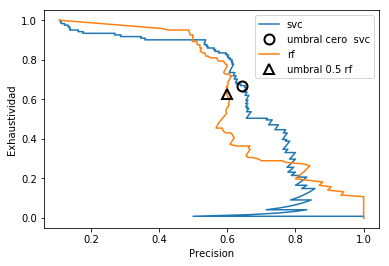

In [16]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=0, max_features=2)
rf.fit(X_entrenamiento, y_entrenamiento)

# RandomForestClassifier tiene predict_proba, pero no decision_function
precision_rf, exhaustividad_rf, umbrales_rf = precision_recall_curve(
    y_prueba, rf.predict_proba(X_prueba)[:, 1])
plt.plot(precision, exhaustividad, label="svc")

plt.plot(precision[cerca_cero], exhaustividad[cerca_cero], 'o', markersize=10,
                   label="umbral cero  svc", fillstyle="none", c='k', mew=2)
plt.plot(precision_rf, exhaustividad_rf, label="rf")

cerca_estandar_rf = np.argmin(np.abs(umbrales_rf - 0.5))
plt.plot(precision_rf[cerca_estandar_rf], exhaustividad_rf[cerca_estandar_rf], '^', c='k',
         markersize=10, label="umbral 0.5 rf", fillstyle="none", mew=2)
plt.xlabel("Precision")
plt.ylabel("Exhaustividad")
plt.legend(loc="best")
plt.show()

A partir del gráfico de comparación, podemos ver que el bosque aleatorio tiene un mejor rendimiento en los extremos, para una exhaustividad  muy alta o requisitos de muy alta precisión. Alrededor del medio (aproximadamente precisión = 0.7), el SVM funciona mejor. Si solo miramos el puntaje f1 para comparar el desempeño general, nos perderíamos estas sutilezas. El puntaje f1 solo captura un punto en la curva de recuperación de precisión, el que viene dado por el umbral predeterminado:

In [19]:
from sklearn.metrics import f1_score
print("f1_score de bosques aleatorios: {:.3f}".format(
    f1_score(y_prueba, rf.predict(X_prueba))))
print("f1_score de svc: {:.3f}".format(f1_score(y_prueba, svc.predict(X_prueba))))

f1_score de bosques aleatorios: 0.610
f1_score de svc: 0.656


La comparación de dos curvas de precisión-exhaustividad  proporciona una gran cantidad de información detallada, pero es un proceso bastante manual. Para la comparación automática del modelo, podríamos resumir la información contenida en la curva, sin limitarnos a un umbral o punto de operación particular. Una forma particular de resumir la curva de precisión-exhaustividad es calcular la integral o el área bajo la curva de precisión-exhaustividad, también conocida como precisión promedio.

Se puede usar la función `average_precision_score` para calcular la precisión promedio. Debido a que necesitamos calcular la curva ROC y considerar múltiples umbrales, el resultado de `decision_function` o `predic_proba` debe pasarse a `average_precision_score`, no el resultado de `predict`:

In [20]:
from sklearn.metrics import average_precision_score
ap_rf = average_precision_score(y_prueba, rf.predict_proba(X_prueba)[:, 1])
ap_svc = average_precision_score(y_prueba, svc.decision_function(X_prueba))
print("Precision promedio de bosques aleatorios: {:.3f}".format(ap_rf))
print("Precision promedio de svc: {:.3f}".format(ap_svc))

Precision promedio de bosques aleatorios: 0.660
Precision promedio de svc: 0.666


Al promediar todos los umbrales posibles, vemos que el bosque aleatorio y el SVC funcionan de manera similar, con el bosque aleatorio incluso ligeramente adelantado. Esto es bastante diferente del resultado que obtuvimos de `f1_score` anteriormente. Debido a que la precisión promedio es el área bajo una curva que va de 0 a 1, la precisión promedio siempre devuelve un valor entre 0 (peor) y 1 (mejor). La precisión promedio de un clasificador que asigna `decision_function` al azar es la fracción de muestras positivas en el conjunto de datos.

### Características operativa del receptor (ROC) y AUC

Hay otra herramienta que se usa comúnmente para analizar el comportamiento de los clasificadores en diferentes umbrales: la curva de características operativas del receptor o la curva ROC para abreviar. De forma similar a la curva de precisión-exhaustividad, la curva ROC considera todos los umbrales posibles para un clasificador dado, pero en lugar de informar la precisión y la exhaustividad, muestra la tasa de falsos positivos (FPR) frente a la tasa de positivos verdaderos (TPR). Se debe recordar  que la tasa positiva verdadera es simplemente otro nombre para exhaustividad, mientras que la tasa de falsos positivos es la fracción de falsos positivos de todas las muestras negativas:

$FPR = \frac{FP}{FP +TN}$

La curva ROC, puede ser calculada por la función `roc_curve`.


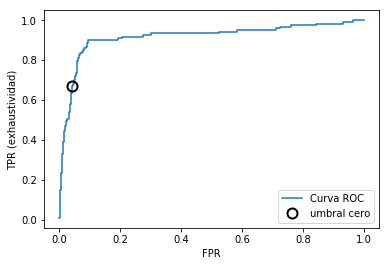

In [22]:
from sklearn.metrics import roc_curve
fpr, tpr, umbrales = roc_curve(y_prueba, svc.decision_function(X_prueba))
plt.plot(fpr, tpr, label="Curva ROC ")
plt.xlabel("FPR")
plt.ylabel("TPR (exhaustividad)")

# encontramos umbrales cercanos a cero 
cerca_cero = np.argmin(np.abs(umbrales))
plt.plot(fpr[cerca_cero], tpr[cerca_cero], 'o', markersize=10,
label="umbral cero", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)
plt.show()

Para la curva ROC, la curva ideal está cerca de la esquina superior izquierda: se desea un clasificador que produzca un alto nivel de exhaustividad mientras mantiene una baja tasa de falsos positivos. En comparación con el umbral predeterminado de 0, la curva muestra que podemos lograr una exhaustividad significativamente mayor (alrededor de 0,9) al tiempo que aumentamos ligeramente la FPR.

El punto más cercano a la esquina superior izquierda podría ser un mejor punto de operación que el elegido por defecto. De nuevo, tenga en cuenta que la elección de un umbral no se debe hacer en el conjunto de prueba, sino en un conjunto de validación por separado.

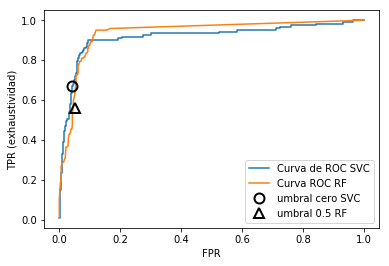

In [25]:
from sklearn.metrics import roc_curve

fpr_rf, tpr_rf, umbrales_rf = roc_curve(y_prueba, rf.predict_proba(X_prueba)[:, 1])
plt.plot(fpr, tpr, label="Curva de ROC SVC")
plt.plot(fpr_rf, tpr_rf, label="Curva ROC RF")
plt.xlabel("FPR")
plt.ylabel("TPR (exhaustividad)")

plt.plot(fpr[cerca_cero], tpr[cerca_cero], 'o', markersize=10,
label="umbral cero SVC", fillstyle="none", c='k', mew=2)
cerca_estandar_rf = np.argmin(np.abs(umbrales_rf - 0.5))
plt.plot(fpr_rf[cerca_estandar_rf], tpr[cerca_estandar_rf], '^', markersize=10,
label="umbral 0.5 RF", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)
plt.show()

En cuanto a la curva  precisión-exhaustividad, a menudo queremos resumir la curva ROC usando un solo número, el área bajo la curva (esto comúnmente se conoce como el AUC, y se entiende que la curva en cuestión es la curva ROC ) Podemos calcular el área bajo la curva ROC usando la función roc_auc_score:

In [28]:
from sklearn.metrics import roc_auc_score
rf_auc = roc_auc_score(y_prueba, rf.predict_proba(X_prueba)[:, 1])
svc_auc = roc_auc_score(y_prueba, svc.decision_function(X_prueba))
print("AUC para bosques aleatorios: {:.3f}".format(rf_auc))
print("AUC para SVC: {:.3f}".format(svc_auc))

AUC para bosques aleatorios: 0.937
AUC para SVC: 0.916


Comparando el bosque aleatorio y SVM usando el puntaje AUC, encontramos que el bosque aleatorio se comporta bastante mejor que el SVM. Recuerda que, dado que la precisión promedio es el área bajo una curva que va de 0 a 1, la precisión promedio siempre devuelve un valor entre 0 (peor) y 1 (mejor). La predicción aleatoria siempre produce un AUC de 0.5, sin importar qué tan desbalanceadas estén las clases en un conjunto de datos. Esto hace que AUC sea una métrica mucho mejor para los problemas de clasificación desbalanceadas que la precisión.

El AUC puede interpretarse como una evaluación del ranking de muestras positivas. Es equivalente a la probabilidad de que un punto escogido al azar de la clase positiva tenga una puntuación más alta de acuerdo con el clasificador que un punto escogido al azar de la clase negativa. Por lo tanto, un AUC perfecto de 1 significa que todos los puntos positivos tienen una puntuación más alta que todos los puntos negativos. Para problemas de clasificación con clases desbalanceadas, el uso de AUC para la selección del modelo a menudo es mucho más significativo que el uso de la precisión.

#### Ejemplo

Clasifiquemos  todos los nueves en el conjunto de datos de `digits` frente a todos los demás dígitos. Clasificaremos el conjunto de datos con un SVM con tres configuraciones diferentes del ancho de banda del kernel, `gamma`:

gamma = 1.00 precision = 0.90 AUC = 0.50
gamma = 0.05 precision = 0.90 AUC = 1.00
gamma = 0.01 precision = 0.90 AUC = 1.00


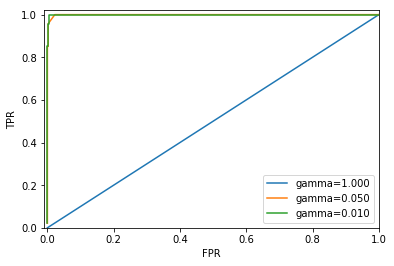

In [31]:
from sklearn.datasets import load_digits

digitos = load_digits()
y = digitos.target == 9

X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(
digitos.data, y, random_state=0)
plt.figure()
for gamma in [1, 0.05, 0.01]:
    svc = SVC(gamma=gamma).fit(X_entrenamiento, y_entrenamiento)
    precision = svc.score(X_prueba, y_prueba)
    
    auc = roc_auc_score(y_prueba, svc.decision_function(X_prueba))
    fpr, tpr, _ = roc_curve(y_prueba , svc.decision_function(X_prueba))
    print("gamma = {:.2f} precision = {:.2f} AUC = {:.2f}".format(gamma, precision, auc))
    plt.plot(fpr, tpr, label="gamma={:.3f}".format(gamma))

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim(-0.01, 1)
plt.ylim(0, 1.02)
plt.legend(loc="best")
plt.show()

La precisión de las tres configuraciones de gamma es el, 90%. Esto podría ser lo mismo que un rendimiento aleatorio, o podría no serlo. Sin embargo, al observar el AUC y la curva correspondiente, vemos una clara distinción entre los tres modelos. Con gamma = 1.0, el AUC está realmente en el nivel aleatorio, lo que significa que el resultado de `decision-function` es tan bueno como aleatorio. Con gamma = 0.05, el rendimiento mejora drásticamente a un AUC de 0.5. Finalmente, con gamma = 0.01, obtenemos un AUC perfecto de 1.0. Eso significa que todos los puntos positivos se clasifican por encima de todos los puntos negativos según la función de decisión. 

En otras palabras, con el umbral correcto, este modelo puede clasificar los datos perfectamente. Sabiendo esto, podemos ajustar el umbral en este modelo y obtener grandes predicciones. Si solo hubiéramos utilizado la precisión, nunca hubiéramos descubierto esto.  Por esta razón, recomendamos encarecidamente el uso de AUC al evaluar modelos en datos desbalanceados. Se debe tener  en cuenta que AUC no hace uso del umbral predeterminado, por lo que puede ser necesario ajustar el umbral de decisión para obtener resultados de clasificación útiles de un modelo con un AUC alto.

### Métricas para clasificación multiclase

Todas las métricas para la clasificación multiclase se derivan de las métricas de clasificación binaria, pero se promedian en todas las clases. La precisión de la clasificación multiclase se define nuevamente como la fracción de ejemplos correctamente clasificados. Y nuevamente, cuando las clases están desbalanceadas, la precisión no es una gran medida de evaluación.

Imaginemos un problema de clasificación de tres clases con un 85% de puntos pertenecientes a la clase A, un 10% perteneciente a la clase B y un 5% perteneciente a la clase C. ¿Qué significa tener un 85% de precisión en este conjunto de datos? En general, los resultados de la clasificación multiclase son más difíciles de entender que los resultados de la clasificación binaria.

Además de la precisión, en estos casos, las herramientas comunes son la matriz de confusión y el informe de clasificación que vimos en el caso binario. Vamos a aplicar estos dos métodos de evaluación detallados en la tarea de clasificar los 10 dígitos manuscritos diferentes en el conjunto de datos `digits`:


In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(
digitos.data, digitos.target, random_state=0)

lr = LogisticRegression().fit(X_entrenamiento, y_entrenamiento)
pred = lr.predict(X_prueba)
print("Precision: {:.3f}".format(accuracy_score(y_prueba, pred)))
print("Matriz de confusion:\n{}".format(confusion_matrix(y_prueba, pred)))

Precision: 0.953
Matriz de confusion:
[[37  0  0  0  0  0  0  0  0  0]
 [ 0 39  0  0  0  0  2  0  2  0]
 [ 0  0 41  3  0  0  0  0  0  0]
 [ 0  0  1 43  0  0  0  0  0  1]
 [ 0  0  0  0 38  0  0  0  0  0]
 [ 0  1  0  0  0 47  0  0  0  0]
 [ 0  0  0  0  0  0 52  0  0  0]
 [ 0  1  0  1  1  0  0 45  0  0]
 [ 0  3  1  0  0  0  0  0 43  1]
 [ 0  0  0  1  0  1  0  0  1 44]]


El modelo tiene una precisión del 95.3%, lo que nos dice que lo estamos haciendo bastante bien. La matriz de confusión nos proporciona más detalles. En cuanto al caso binario, cada fila corresponde a una etiqueta verdadera y cada columna corresponde a una etiqueta predicha. Se puede encontrar un gráfico  visualmente más informativo:

In [38]:
def mapa_calor(valores, xetiqueta, yetiqueta, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    if ax is None:
        ax = plt.gca()
    # dibuja los puntajes mediosde validación cruzada
    img = ax.pcolor(valores, cmap=cmap, vmin=vmin, vmax=vmax)
    img.update_scalarmappable()
    ax.set_xlabel(xetiqueta)
    ax.set_ylabel(yetiqueta)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    for p, color, valor in zip(img.get_paths(), img.get_facecolors(),
                               img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % valor, color=c, ha="center", va="center")
    return img

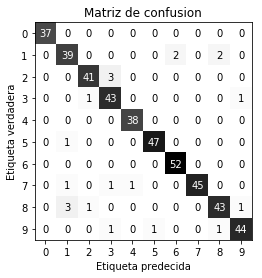

In [42]:
imagen_puntuacion = mapa_calor(confusion_matrix(y_prueba, pred), xetiqueta='Etiqueta predecida',
                               yetiqueta='Etiqueta verdadera', xticklabels=digitos.target_names,
                                yticklabels=digitos.target_names, cmap=plt.cm.gray_r, fmt="%d")
plt.title("Matriz de confusion")
plt.gca().invert_yaxis()

Para la primera clase, el dígito 0, hay 37 muestras en la clase  y todas estas muestras se clasificaron como clase 0 (no hay falsos negativos para la clase 0). Podemos ver eso porque todas las demás entradas en la primera fila de la matriz de confusión son 0. También podemos ver que ningún otro dígito se clasificó erróneamente como 0, porque todas las demás entradas en la primera columna de la matriz de confusión son 0 (no hay falsos positivos para la clase 0). Sin embargo, algunos dígitos se confundieron con otros, por ejemplo, el dígito 2 (tercera fila), tres de los cuales se clasificaron como el dígito 3 (cuarta columna). También hubo un dígito 3 que se clasificó como 2 (tercera columna, cuarta fila) y un dígito 8 que se clasificó como 2 (columna tercera, cuarta fila).

Con la función `classification_report`, podemos calcular la precisión, exhaustividady `f-score` para cada clase:

In [44]:
from sklearn.metrics import classification_report
print(classification_report(y_prueba, pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        37
          1       0.89      0.91      0.90        43
          2       0.95      0.93      0.94        44
          3       0.90      0.96      0.92        45
          4       0.97      1.00      0.99        38
          5       0.98      0.98      0.98        48
          6       0.96      1.00      0.98        52
          7       1.00      0.94      0.97        48
          8       0.93      0.90      0.91        48
          9       0.96      0.94      0.95        47

avg / total       0.95      0.95      0.95       450



Como era de esperar, la precisión y la exhaustividad son un 1 perfecto para la clase 0, ya que no hay confusiones con esta clase. Para la clase 7, por otro lado, la precisión es 1, porque ninguna otra clase se clasificó erróneamente como 7, mientras que para la clase 6, no hay falsos negativos, por lo que la exhaustividad es 1. También podemos ver que el modelo tiene dificultades particulares con clases 8 y 3.

La métrica  comúnmente utilizada para los conjuntos de datos desbalanceados  en la configuración de multiclases es la versión multiclase de `f-score`. La idea detrás del `f-scale` multiclase es calcular un `f-score` binario por clase, siendo esa clase la clase positiva y las otras clases conformando  las clases negativas. Luego, estas `f-score` por clase se promedian utilizando una de las siguientes estrategias:

* El promedio "macro", calcula los `f-score` por clase no ponderados. Da igual peso para todas las clases, sin importar su tamaño.
* El promedio "weighted ", calcula la media de los `f-score` por clase, ponderados por su soporte. Esto es lo que se indica  en el informe de clasificación.

* El promedio "micro" calcula la cantidad total de falsos positivos, falsos negativos y verdaderos positivos en todas las clases, y luego calcula la precisión, la exhaustividad y el `f-score ` usando este valor.


Si te importa cada muestra por igual, se recomienda utilizar el promedio "micro"; si te preocupa por cada clase por igual, se recomienda utilizar el promedio macro":

In [45]:
print("Promedio micro f1-score: {:.3f}".format(f1_score(y_prueba, pred, average="micro")))
print("Promedio macro f1-score: {:.3f}".format(f1_score(y_prueba, pred, average="macro")))

Promedio micro f1-score: 0.953
Promedio macro f1-score: 0.954


### Métricas de regresión

La evaluación para la regresión se puede hacer con detalles similares a los de la clasificación, por ejemplo, analizando la sobrepredicción  del objetivo versus la predicción insuficiente del objetivo. Sin embargo, en la mayoría de las aplicaciones que hemos visto, usar el $R^2$ predeterminado utilizado en el método `score` de todos los regresores es suficiente. En ocasiones, las decisiones comerciales se toman sobre la base de un error cuadrático medio o un error absoluto medio, lo que podría incentivar a ajustar  los modelos que utilizan estas métricas. Sin embargo, en general, hemos encontrado que $R^2$ es una medida más intuitiva para evaluar los modelos de regresión.

### Uso de métricas de evaluación en la selección de modelos

A menudo deseamos usar métricas como AUC en la selección de modelos usando `GridSearchCV` o `cross_val_score`. Afortunadamente scikit-learn proporciona una forma muy simple de lograr esto, a través del argumento `scoring` que se puede usar tanto en GridSearchCV como en cross_val_score. Simplemente se proporciona  una cadena que describa la métrica de evaluación que desea usar.

Digamos, por ejemplo, que queremos evaluar el clasificador SVM en la tarea "nueve vs. no nueve" en el conjunto de datos `digits`, usando la puntuación AUC. Cambiar el puntaje del valor predeterminado (precisión) a AUC se puede hacer proporcionando "roc_auc" como el parámetro `scoring`:

In [47]:
from sklearn.model_selection import cross_val_score

# Puntuacion predeterminado para la clasificación es la precisión
print("Puntuacion predeterminado: {}".format(
    cross_val_score(SVC(), digitos.data, digitos.target == 9)))

# Si scoring="precision" no cambia los resultados
precision_explicita = cross_val_score(SVC(), digitos.data, digitos.target == 9, 
                            scoring="accuracy")
print("Puntuacion de precision explicita: {}".format(precision_explicita))
roc_auc = cross_val_score(SVC(), digitos.data, digitos.target == 9,
                          scoring="roc_auc")
print("Puntuacion AUC: {}".format(roc_auc))

Puntuacion predeterminado: [0.89983306 0.89983306 0.89983306]
Puntuacion de precision explicita: [0.89983306 0.89983306 0.89983306]
Puntuacion AUC: [0.99372294 0.98957947 0.99594929]


Del mismo modo, podemos cambiar la métrica utilizada para elegir los mejores parámetros en Gridsearchcv:

In [52]:
from sklearn.model_selection import GridSearchCV

X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(
digitos.data, digitos.target == 9, random_state=0)

# proporcionamos un grid algo mala  para ilustrar el punto:
parametros_grid = {'gamma': [0.0001, 0.01, 0.1, 1, 10]}

# utilizando la puntuacion predeterminada de precision:
grid = GridSearchCV(SVC(), param_grid=parametros_grid)
grid.fit(X_entrenamiento, y_entrenamiento)
print("Grid-Search con precision:")
print("Mejores parametros:", grid.best_params_)
print("Mejor puntuacion de validación cruzada (precision)): {:.3f}".format(grid.best_score_))
print("Conjunto de prueba AUC: {:.3f}".format(
roc_auc_score(y_prueba, grid.decision_function(X_prueba))))
print("Precision del conjunto de prueba: {:.3f}".format(grid.score(X_prueba, y_prueba)))

Grid-Search con precision:
Mejores parametros: {'gamma': 0.0001}
Mejor puntuacion de validación cruzada (precision)): 0.970
Conjunto de prueba AUC: 0.992
Precision del conjunto de prueba: 0.973


Usando la puntuación AUC en su lugar:

In [53]:
grid = GridSearchCV(SVC(), param_grid=parametros_grid, scoring="roc_auc")
grid.fit(X_entrenamiento, y_entrenamiento)
print("Grid-Search con AUC:")
print("Mejores parametros:", grid.best_params_)
print("Mejor puntuacion de validación cruzada (precision)): {:.3f}".format(grid.best_score_))
print("Conjunto de prueba AUC: {:.3f}".format(
roc_auc_score(y_prueba, grid.decision_function(X_prueba))))
print("Precision del conjunto de prueba: {:.3f}".format(grid.score(X_prueba, y_prueba)))

Grid-Search con AUC:
Mejores parametros: {'gamma': 0.01}
Mejor puntuacion de validación cruzada (precision)): 0.997
Conjunto de prueba AUC: 1.000
Precision del conjunto de prueba: 1.000


Cuando se utiliza la precisión, se selecciona el parámetro `gamma = 0.0001`, mientras que `gamma = 0.01` se selecciona cuando se usa AUC. La precisión de validación cruzada es consistente con la precisión del conjunto de prueba en ambos casos. Sin embargo, el uso de AUC encontró una mejor configuración de parámetros en términos de AUC e incluso en términos de precisión.

Encontrar una solución de mayor precisión con AUC es probablemente una consecuencia de que la precisión sea una mala medida del rendimiento del modelo en datos desbalanceados.

Los valores más importantes para el parámetro `scoring ` para la clasificación son `accuracy` (predeterminado); `roc_auc` para el área bajo la curva ROC; `average_precision` para el área bajo la curva de exhaustividad-precisión; `f1`, `f1_macro`, `f1_micro` y `f1_weighted` para el `f1-score ` binario y las diferentes variantes ponderadas. Para la regresión, los valores más comúnmente utilizados son `r2` para el puntaje $R^2$, `mean_squared_error` para el error cuadrático medio y `mean_absolute_error` para el error absoluto medio. 

Se puede encontrar una lista completa de los argumentos admitidos en la documentación o consultando el diccionario `SCORER` definido en el módulo `metrics.scorer`:


In [54]:
from sklearn.metrics.scorer import SCORERS
print("Disponibles argumentos para scoring:\n{}".format(sorted(SCORERS.keys())))

Disponibles argumentos para scoring:
['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'log_loss', 'mean_absolute_error', 'mean_squared_error', 'median_absolute_error', 'mutual_info_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'v_measure_score']
